## Programming 2.2
### K-Means, Mixture Models and EM Algorithms (25 points)

**Datasets:**
- `abalone` - from UCI Repository: [Abalone Dataset](https://archive.ics.uci.edu/dataset/1/abalone)

**Task:**
- Predict the age of abalones using KNN and GMM.

**Reference:**
- [Learn by Example: Expectation Maximization](https://www.kaggle.com/code/charel/learn-by-example-expectation-maximization/notebook)

**Note:**
- Please follow the instructions below and implement tasks.
- Ensure that your code is executable. Otherwise, points for the respective question will be deducted.

In [1]:
# import libraries
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform

RANDOM_SEED = 3020

### Data Pre-Processing

- (i) Load data into python and print information about the dataframe.

In [2]:
import pandas as pd

# read abalone.data file
abalone = pd.read_csv('abalone.data', header=None)

abalone.head(5)

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


- (ii) Assign exact column names to dataframe

In [3]:
# get names of columns from abalone.names file
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

# assign column names
abalone.columns = columns

abalone.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


- (iii)  Check missing values.

In [4]:
# check for missing values in abalone
abalone.isnull().sum()


Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

- (iv) Perform one-hot encoding to ’sex’.

In [5]:
abalone = pd.get_dummies(abalone, columns=['Sex'])

abalone.head(5)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


- (v) Perform min-max normalization on numerical variables

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Select the numeric columns to be normalized
numeric_cols = abalone.select_dtypes(include=['float64', 'int64']).columns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the numeric columns
abalone[numeric_cols] = scaler.fit_transform(abalone[numeric_cols])

abalone.head(5)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0.500000,False,False,True
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0.214286,False,False,True
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,0.285714,True,False,False
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,0.321429,False,False,True
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,0.214286,False,True,False


- (vi) Transform target variable: (’Rings’+ 1.5 = Age (yrs)) and remove ’Rings’ in dataframe.

In [7]:
# Transform target variable: (’Rings’+ 1.5 = Age (yrs)) and remove ’Rings’ in dataframe
abalone['Age (yrs)'] = abalone['Rings'] + 1.5
abalone.drop('Rings', axis=1, inplace=True)

abalone.head(5)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M,Age (yrs)
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,False,False,True,2.000000
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,False,False,True,1.714286
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,True,False,False,1.785714
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,False,False,True,1.821429
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,False,True,False,1.714286


- (vii) Plot bar charts for numerical variables.

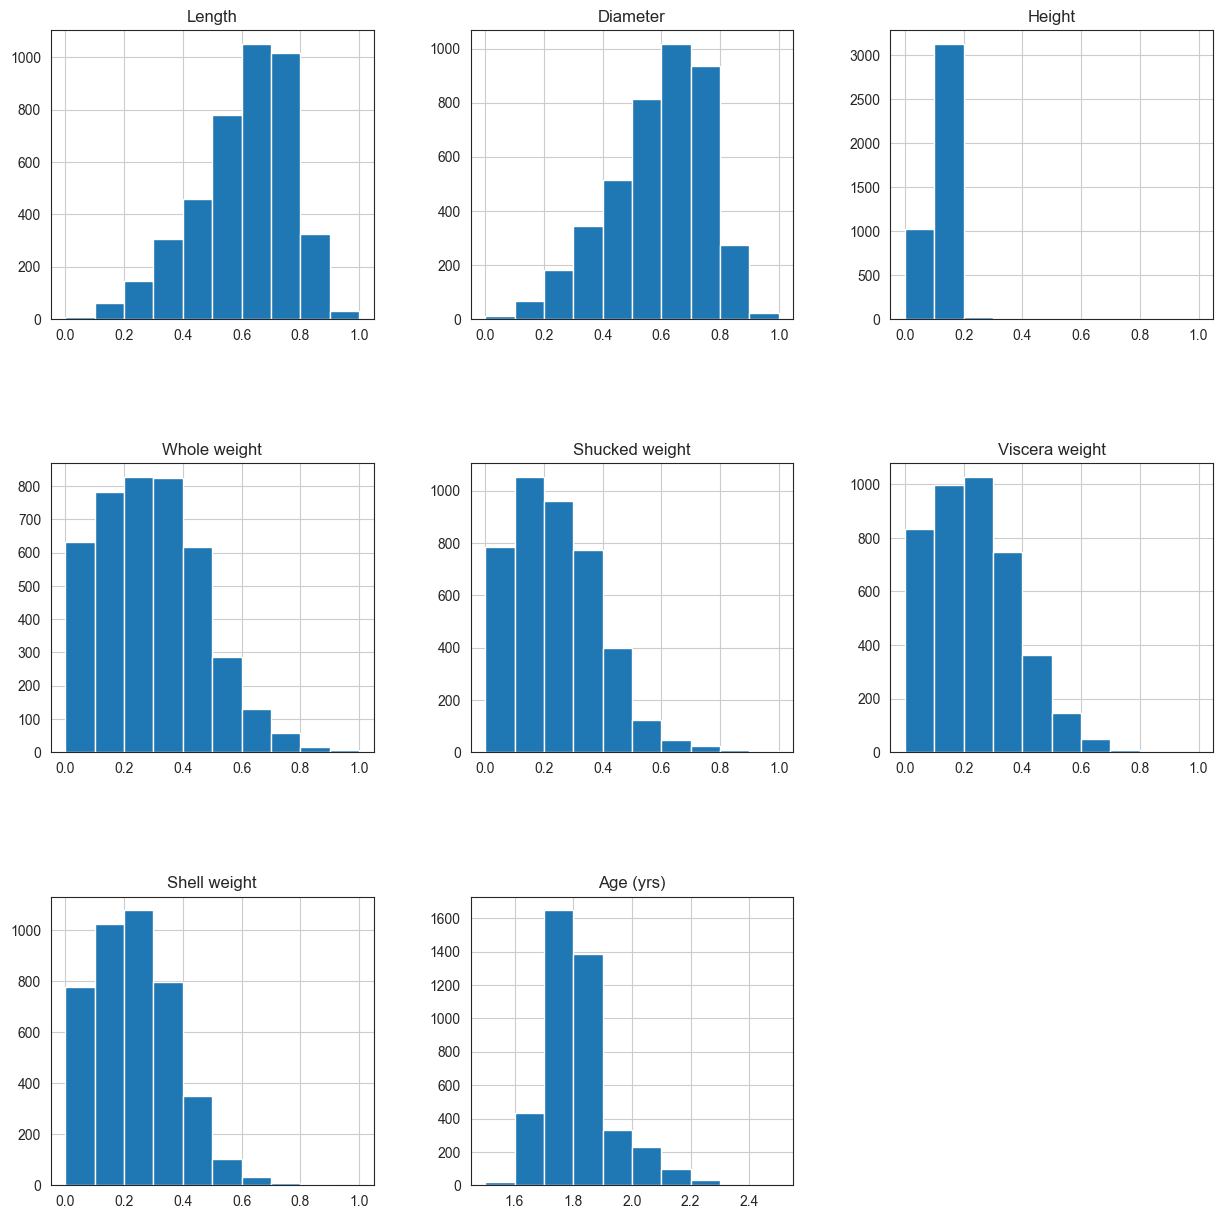

In [8]:
# Plot bar charts for numerical variables.
import matplotlib.pyplot as plt

# Plot bar charts for numerical variables
abalone.hist(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.show()


### K-Means Clustering (using sklearn)

- (i) Construct a model with k = 5

In [9]:
from sklearn.cluster import KMeans

# Create a KMeans object with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED)

X = abalone[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']]

# Fit the data
kmeans.fit(X)

KMeans(n_clusters=5, random_state=3020)

- (ii) Compute and print the silhouette coefficients

In [10]:
from sklearn.metrics import silhouette_score

# Compute the silhouette scores for each sample
silhouette_vals_kmeans = silhouette_score(X, kmeans.labels_)
print(f"Q2.2.2 (ii) Silhouette Coefficient (K Means): {silhouette_vals_kmeans:.5f}")

Q2.2.2 (ii) Silhouette Coefficient (K Means): 0.57271


### GMM and EM Algorithms

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0


C:\Users\Z4N3R\AppData\Local\Temp\ipykernel_30104\1089493877.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, bins=20, kde=False);


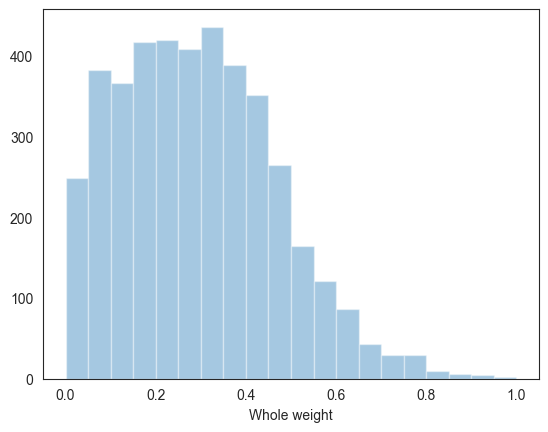

In [11]:
np.random.seed(RANDOM_SEED)

Mean1 = 2.0  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4.0 #@param {type:"number"}
Mean2 = 9.0 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2.0 #@param {type:"number"}

data = abalone['Whole weight']

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
sns.distplot(data, bins=20, kde=False);

- (i) Fit Gaussian Mixture Model with 2 Gaussians on `[’Whole weights’]` using EM Algorithm
(choose number of iteration = `20`).

**without sklearn**

In [12]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("done")

done


In [13]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")

done


In [14]:
# See the algorithm in action
n_iterations = 20
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass

 1 Mixture: Gaussian(0.291739, 0.173373), Gaussian(0.293877, 0.173941), mix=0.5)
 1 Mixture: Gaussian(0.291588, 0.173092), Gaussian(0.294027, 0.174219), mix=0.5)
 1 Mixture: Gaussian(0.291289, 0.172772), Gaussian(0.294326, 0.174532), mix=0.5)
 1 Mixture: Gaussian(0.290823, 0.172374), Gaussian(0.294793, 0.174915), mix=0.5)
 1 Mixture: Gaussian(0.290151, 0.171853), Gaussian(0.295465, 0.17541), mix=0.5)
 1 Mixture: Gaussian(0.289212, 0.171153), Gaussian(0.296404, 0.176059), mix=0.5)
 1 Mixture: Gaussian(0.287925, 0.170204), Gaussian(0.297692, 0.176916), mix=0.5)
 1 Mixture: Gaussian(0.286179, 0.168917), Gaussian(0.299439, 0.178033), mix=0.5)
 1 Mixture: Gaussian(0.283847, 0.167189), Gaussian(0.301773, 0.179456), mix=0.5)
 1 Mixture: Gaussian(0.280798, 0.16492), Gaussian(0.304831, 0.181196), mix=0.5)
 1 Mixture: Gaussian(0.276936, 0.162051), Gaussian(0.308717, 0.183191), mix=0.501)
 1 Mixture: Gaussian(0.272257, 0.158623), Gaussian(0.313455, 0.185277), mix=0.501)
 1 Mixture: Gaussian(0.266

- (ii) Plot the fitted GMM

Computing best model with random restarts...

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 0.11, σ = 0.06, weight = 0.23
Gaussian 2: μ = 0.35, σ = 0.16, weight = 0.77


C:\Users\Z4N3R\AppData\Local\Temp\ipykernel_30104\1875977380.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, bins=20, kde=False, norm_hist=True);


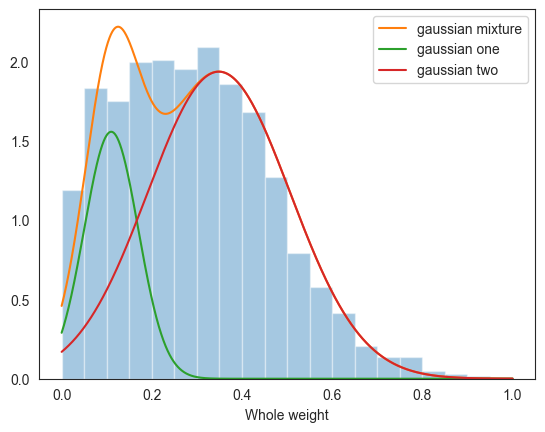

In [15]:
# Find best Mixture Gaussian model
n_iterations = 300
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
#print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))
#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();

- (iii) Now with the help of sklearn, fit GMM with 2 Gaussians on `[’Whole weights’]` again and
Plot fitted GMM.

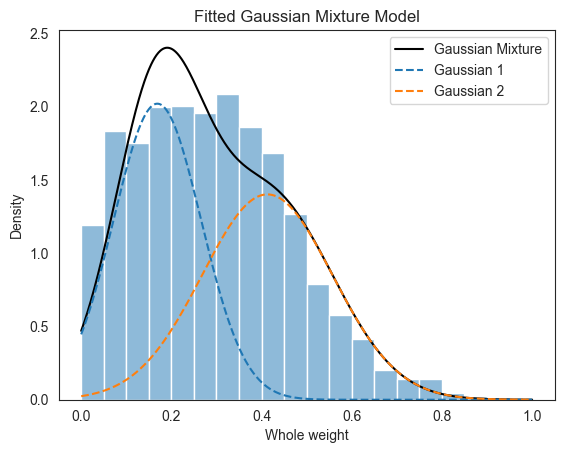

In [16]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the 'Whole weight' column
whole_weight = abalone['Whole weight'].values.reshape(-1, 1)

# Fit a Gaussian Mixture Model with 2 components
gmm_iii = GaussianMixture(n_components=2, max_iter=20, random_state=3020)
gmm_iii.fit(whole_weight)

# Generate a range of values for plotting the GMM_iii
x = np.linspace(whole_weight.min(), whole_weight.max(), 1000).reshape(-1, 1)
logprob = gmm_iii.score_samples(x)
responsibilities = gmm_iii.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the histogram of the data
sns.histplot(whole_weight, bins=20, kde=False, stat='density')

# Plot the fitted GMM_iii
plt.plot(x, pdf, '-k', label='Gaussian Mixture')
plt.plot(x, pdf_individual[:, 0], '--', label='Gaussian 1')
plt.plot(x, pdf_individual[:, 1], '--', label='Gaussian 2')
plt.legend()
plt.xlabel('Whole weight')
plt.ylabel('Density')
plt.title('Fitted Gaussian Mixture Model')
plt.show()

- (iv) Fit a GMM with **all** predictors (using sklearn)

In [17]:
from sklearn.mixture import GaussianMixture

# Extract all predictors (excluding the target variable 'Age (yrs)')
X = abalone.drop(columns=['Age (yrs)']).values

# Fit a Gaussian Mixture Model with 2 components
gmm_all = GaussianMixture(n_components=2, max_iter=20, random_state=RANDOM_SEED)
gmm_all.fit(X)

GaussianMixture(max_iter=20, n_components=2, random_state=3020)

In [ ]:
from sklearn.metrics import silhouette_score

# Predict the labels for gmm all
gmm_all_labels = gmm_all.predict(X)

# Compute the silhouette scores for each sample
silhouette_vals_gmm_all = silhouette_score(X, gmm_all_labels)
print(f"Silhouette Coefficient for GMM (All Mixture): {silhouette_vals_gmm_all:.5f}")

Silhouette Coefficient for GMM (All Mixture): 0.51805


- (v) Compute and print silhouette coefficients for GMM modelled in (iii) and compare it with
your results 2.2.2. Briefly explain your preference.

In [22]:
from sklearn.metrics import silhouette_score

# Predict the labels for gmm_iii
gmm_iii_labels = gmm_iii.predict(whole_weight)

# Compute the silhouette scores
silhouette_vals_gmm_iii = silhouette_score(X, gmm_iii_labels)
print(f"Silhouette Coefficient for GMM (whole weight): {silhouette_vals_gmm_iii:.5f}")

# Compare with KMeans silhouette score
print(f"Silhouette Coefficient for KMeans: {silhouette_vals_kmeans:.5f}")


Silhouette Coefficient for GMM (whole weight): 0.25829
Silhouette Coefficient for KMeans: 0.57271


Preference: KMeans Clustering on all features as it has a higher silhouette coefficient than that of GMM on the `Whole Weights` column in part (iii)